<a href="https://colab.research.google.com/github/r0hit91314/Equity_strategy_nifty50/blob/main/Market_regime_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING LIBRARIES

In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
warnings.filterwarnings("ignore")

# DOWNLOADING HISTORICAL DATA

In [28]:
nifty_50_tickers = [
    "ADANIENT", "ADANIPORTS", "APOLLOHOSP", "ASIANPAINT", "AXISBANK",
    "BAJAJ-AUTO", "BAJFINANCE", "BAJAJFINSV", "BHARTIARTL", "BPCL",
    "BRITANNIA", "CIPLA", "COALINDIA", "DIVISLAB", "DRREDDY", "EICHERMOT",
    "GRASIM", "HCLTECH", "HDFCBANK", "HDFCLIFE", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "ICICIBANK", "INDUSINDBK", "INFY", "ITC", "JSWSTEEL",
    "KOTAKBANK", "LT", "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBILIFE", "SBIN", "SUNPHARMA", "TATACONSUM",
    "TCS", "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "UPL", "ULTRACEMCO",
    "WIPRO", "SBICARD"
]

In [29]:
master_data = {}
for ticker in nifty_50_tickers:
    try:
        df = yf.download(ticker + ".NS", start="2020-01-01", end="2023-10-01")
        df.columns = ["Close" , "High", "Low", "Open", "Volume"]
        master_data[ticker] = df
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# PREPARING DATASETS WITH INDICATORS

In [30]:
def prepare_dataset(stock_data , short_ema, long_ema, adx_period, signal_ema):
    for ticker, df in stock_data.items():

        # ----- RSI ---
        delta = df['Close'].diff()

        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)

        # Use exponential moving average for smoothing
        avg_gain = gain.ewm(span= 14, adjust=False).mean()
        avg_loss = loss.ewm(span= 14, adjust=False).mean()

        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
        # --- MACD ---
        df['EMA_Short'] = df['Close'].ewm(span=short_ema, adjust=False).mean()
        df['EMA_Long'] = df['Close'].ewm(span=long_ema, adjust=False).mean()
        df['MACD'] = df['EMA_Short'] - df['EMA_Long']
        df['MACD_Signal'] = df['MACD'].ewm(span=signal_ema, adjust=False).mean()

        # --- ADX ---
        df['TR'] = df[['High', 'Close']].max(axis=1) - df[['Low', 'Close']].min(axis=1)

        df['+DM'] = df['High'].diff()
        df['-DM'] = -df['Low'].diff()
        df['+DM'] = df['+DM'].where((df['+DM'] > df['-DM']) & (df['+DM'] > 0), 0.0)
        df['-DM'] = df['-DM'].where((df['-DM'] > df['+DM']) & (df['-DM'] > 0), 0.0)

        tr14 = df['TR'].rolling(window=adx_period).sum()
        plus_dm14 = df['+DM'].rolling(window=adx_period).sum()
        minus_dm14 = df['-DM'].rolling(window=adx_period).sum()

        df["p_DI"] = 100 * (plus_dm14 / tr14)
        df["m_DI"] = 100 * (minus_dm14 / tr14)
        dx = 100 * (abs(df["p_DI"] - df["m_DI"]) / (df["p_DI"] + df["m_DI"]))
        df['ADX'] = dx.rolling(window=adx_period).mean()
        df['ADX_Slope'] = df['ADX'] - df['ADX'].shift(3)

        # FOR COMPUTING THE CAMPOSITE SCORE
        df["RS"] = rs
        df['EMA_slope'] = df['EMA_Long'] - df['EMA_Long'].shift(5)
        df['Volatility'] = df['Close'].pct_change().rolling(20).std()

        window = 35  # lookback period for z-score

        df['RS_score'] = (df['RS'] - df['RS'].rolling(window).mean()) / df['RS'].rolling(window).std()
        df['EMA_score'] = (df['EMA_slope'] - df['EMA_slope'].rolling(window).mean()) / df['EMA_slope'].rolling(window).std()
        df["ADX_score"] = (df['ADX'] - df['ADX'].rolling(window).mean()) / df['ADX'].rolling(window).std()

        df["Combined_score"] = 0.4*df["EMA_score"] + 0.3*df["RS_score"] + 0.3*df["ADX_score"]


        # Drop intermediate columns if not needed
        df.drop(columns=['TR' , "+DM" , "-DM"], inplace=True)
        df.dropna(inplace=True)  # Remove rows with NaN values

    return stock_data




In [31]:

def plot_macd_adx(df, ticker):
    plt.figure(figsize=(14, 10))


    # 1. Plot Closing Price (optional)
    plt.subplot(4, 1, 1)
    plt.plot(df['Close'], label='Close Price', color='blue')
    plt.title(f'{ticker} - Closing Price')
    plt.legend()
    plt.grid()

    # 2. Plot MACD and MACD Signal
    plt.subplot(4, 1, 2)
    plt.plot(df['MACD'], label='MACD', color='green')
    plt.plot(df['MACD_Signal'], label='Signal Line', color='red')
    plt.title(f'{ticker} - MACD vs Signal Line')
    plt.legend()
    plt.grid()

    # 3. Plot ADX
    plt.subplot(4, 1, 3)
    plt.plot(df['ADX'], label='ADX', color='purple')
    plt.axhline(25, linestyle='--', color='orange', label='Trend Threshold')
    plt.axhline(0, linestyle='--', color='grey', linewidth=1)
    plt.title(f'{ticker} - ADX')
    plt.legend()
    plt.grid()

    # 4. Plot RSI
    plt.subplot(4, 1, 4)
    plt.plot(df['RSI'], label='RSI', color='black')
    plt.axhline(70, linestyle='--', color='red', label='Overbought')
    plt.axhline(30, linestyle='--', color='green', label='Oversold')
    plt.title(f'{ticker} - RSI')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [32]:
import pandas as pd
import numpy as np

def supertrend(df, period=20, multiplier=3):
    df = df.copy()

    # --- ATR Calculation ---
    df['H-L'] = df['High'] - df['Low']
    df['H-C'] = abs(df['High'] - df['Close'].shift(1))
    df['L-C'] = abs(df['Low'] - df['Close'].shift(1))

    df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    # --- Basic Bands ---
    df['Upper Basic'] = (df['High'] + df['Low']) / 2 + multiplier * df['ATR']
    df['Lower Basic'] = (df['High'] + df['Low']) / 2 - multiplier * df['ATR']

    # --- Final Bands ---
    df['Upper Band'] = 0.0
    df['Lower Band'] = 0.0
    df['Supertrend'] = 0.0
    df['Trend'] = True  # True=Uptrend, False=Downtrend

    for i in range(period, len(df)):
        # Upper Band
        if df['Upper Basic'].iloc[i] < df['Upper Band'].iloc[i-1] or df['Close'].iloc[i-1] > df['Upper Band'].iloc[i-1]:
            df.loc[df.index[i], 'Upper Band'] = df['Upper Basic'].iloc[i]
        else:
            df.loc[df.index[i], 'Upper Band'] = df['Upper Band'].iloc[i-1]

        # Lower Band
        if df['Lower Basic'].iloc[i] > df['Lower Band'].iloc[i-1] or df['Close'].iloc[i-1] < df['Lower Band'].iloc[i-1]:
            df.loc[df.index[i], 'Lower Band'] = df['Lower Basic'].iloc[i]
        else:
            df.loc[df.index[i], 'Lower Band'] = df['Lower Band'].iloc[i-1]

        # Supertrend decision
        if df['Close'].iloc[i] > df['Upper Band'].iloc[i-1]:
            df.loc[df.index[i], 'Supertrend'] = df['Lower Band'].iloc[i]
            df.loc[df.index[i], 'Trend'] = True
        elif df['Close'].iloc[i] < df['Lower Band'].iloc[i-1]:
            df.loc[df.index[i], 'Supertrend'] = df['Upper Band'].iloc[i]
            df.loc[df.index[i], 'Trend'] = False
        else:
            df.loc[df.index[i], 'Supertrend'] = df['Supertrend'].iloc[i-1]
            df.loc[df.index[i], 'Trend'] = df['Trend'].iloc[i-1]

    df.drop(columns= ["H-L" , "H-C" , "L-C" , "TR" , "ATR"] , inplace= True)
    df.dropna(inplace=True)

    return df


### three months of data would be required to prepare the signals

### VISUALIZING THE INDICATORS

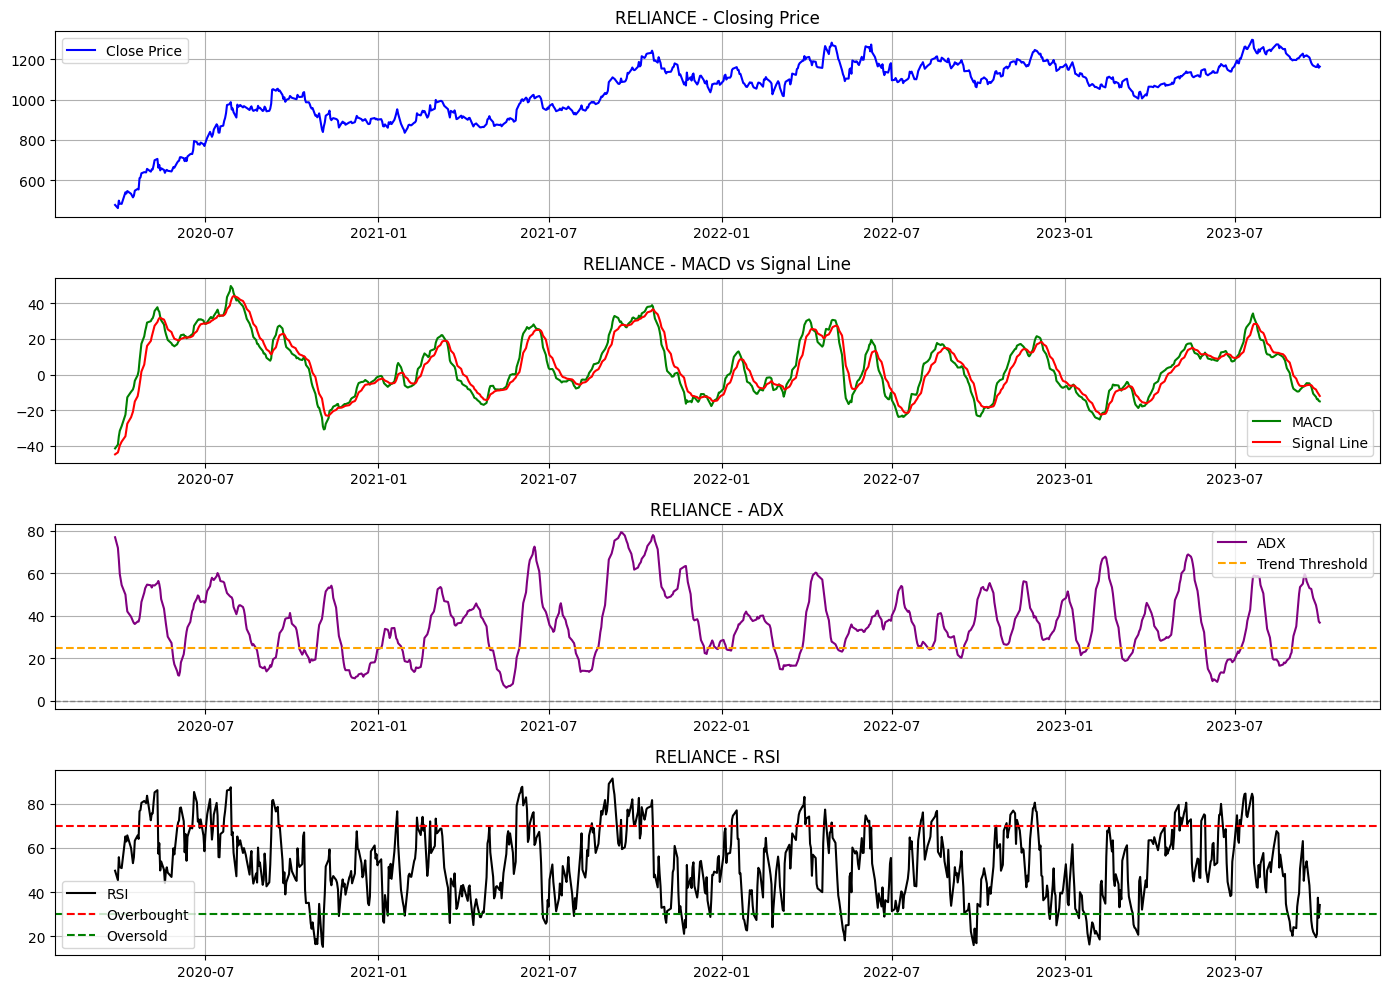

In [33]:
visualize = copy.deepcopy(master_data)
visualize = prepare_dataset(visualize, short_ema=13, long_ema=26, adx_period=14, signal_ema=9)
df = visualize["RELIANCE"]
plot_macd_adx(df, "RELIANCE")

# GENERATING SIGNALS FOR STRATEGY EXECUTION

In [34]:
def generate_signals_1(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df['ADX'][i] > 30) and (df["MACD"][i] > 0) and df["p_DI"][i] > df["m_DI"][i]:
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            elif df['MACD'][i] < df['MACD_Signal'][i] and df['ADX'][i] > 30 and df["MACD"][i] < 0 and df["p_DI"][i] < df["m_DI"][i]:
                df.at[df.index[i], 'Signal'] = -1  # Sell signal
            if i == 0:
                continue
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1  # Exit position
            elif (df['MACD'][i] > df['MACD_Signal'][i] and df['Signal'][i-1] == -1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1


    return stock_data

In [35]:
def generate_signals_2(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df['ADX'][i] > 30) and (df["MACD"][i] > 0) and df["p_DI"][i] > df["m_DI"][i] and (df["RSI"][i] < 70):
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            elif df['MACD'][i] < df['MACD_Signal'][i] and df['ADX'][i] > 30 and df["MACD"][i] < 0 and df["p_DI"][i] < df["m_DI"][i] and (df["RSI"][i] > 40):
                df.at[df.index[i], 'Signal'] = -1  # Sell signal
            if i == 0:
                continue
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1  # Exit position
            elif (df['MACD'][i] > df['MACD_Signal'][i] and df['Signal'][i-1] == -1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1


    return stock_data

In [36]:
def generate_signals_3(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df['ADX'][i] > 30) and (df["MACD"][i] > 0) and df["p_DI"][i] > df["m_DI"][i] and (df["ADX_Slope"][i] > 0) and (df["Combined_score"][i] > 0):
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            elif df['MACD'][i] < df['MACD_Signal'][i] and df['ADX'][i] > 30 and df["MACD"][i] < 0 and df["p_DI"][i] < df["m_DI"][i] and (df["ADX_Slope"][i] > 0):
                df.at[df.index[i], 'Signal'] = -1  # Sell signal
            if i == 0:
                continue
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1  # Exit position
            elif (df['MACD'][i] > df['MACD_Signal'][i] and df['Signal'][i-1] == -1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1


    return stock_data

In [37]:
def generate_signals_4(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df['ADX'][i] > 30) and (df["MACD"][i] > 0) and df["p_DI"][i] > df["m_DI"][i] and (df["ADX_Slope"][i] > 0) and (df["RSI"][i] < 70) :
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            elif df['MACD'][i] < df['MACD_Signal'][i] and df['ADX'][i] > 30 and df["MACD"][i] < 0 and df["p_DI"][i] < df["m_DI"][i] and (df["ADX_Slope"][i] > 0) and (df["RSI"][i] > 40):
                df.at[df.index[i], 'Signal'] = -1  # Sell signal
            if i == 0:
                continue
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1  # Exit position
            elif (df['MACD'][i] > df['MACD_Signal'][i] and df['Signal'][i-1] == -1) or (df['ADX'][i] < 25):
                df.at[df.index[i], 'exit'] = 1


    return stock_data

In [38]:
def generate_signals_5(stock_data):
    for ticker, df in stock_data.items():
        df['Signal'] = 0  # Default to no signal
        df['exit'] = 0  # Default to no position

        for i in range(0, len(df)):
            if i == 0:
                continue
            if (df['MACD'][i] > df['MACD_Signal'][i]) and (df["MACD"][i] > 0) and (df["ADX_Slope"][i] > 0):
                df.at[df.index[i], 'Signal'] = 1  # Buy signal
            # Exit logic
            if (df['MACD'][i] < df['MACD_Signal'][i] and df['Signal'][i-1] == 1):
                df.at[df.index[i], 'exit'] = 1  # Exit position


    return stock_data

# Signal Generation Comparison Table

| Feature            | generate_signals_1                                                                                              | generate_signals_2                                                        | generate_signals_3                                                                                                    | generate_signals_4                                                                                                          |
|--------------------|----------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------|
| **Buy Signal**     | - `MACD > MACD_Signal`<br>- `ADX > 30`<br>- `MACD > 0`<br>- `p_DI > m_DI`<br>- `RSI < 70`                      | - `MACD > MACD_Signal`<br>- `ADX > 30`<br>- `MACD > 0`<br>- `p_DI > m_DI` | - `MACD > MACD_Signal`<br>- `ADX > 30`<br>- `MACD > 0`<br>- `p_DI > m_DI`<br>- `ADX_Slope > 0`                    | - `MACD > MACD_Signal`<br>- `ADX > 30`<br>- `MACD > 0`<br>- `p_DI > m_DI`<br>- `ADX_Slope > 0`<br>- `RSI < 70`              |
| **Sell Signal**    | - `MACD < MACD_Signal`<br>- `ADX > 30`<br>- `MACD < 0`<br>- `p_DI < m_DI`<br>- `RSI > 40`                      | - `MACD < MACD_Signal`<br>- `ADX > 30`<br>- `MACD < 0`<br>- `p_DI < m_DI` | - `MACD < MACD_Signal`<br>- `ADX > 30`<br>- `MACD < 0`<br>- `p_DI < m_DI`<br>- `ADX_Slope > 0`                    | - `MACD < MACD_Signal`<br>- `ADX > 30`<br>- `MACD < 0`<br>- `p_DI < m_DI`<br>- `ADX_Slope > 0`<br>- `RSI > 40`              |
| **Extra Buy Filter**   | `RSI < 70`                                                                                                    | none                                                                     | `ADX_Slope > 0`                                                                                                      | `ADX_Slope > 0`<br>`RSI < 70`                                                                                              |
| **Extra Sell Filter**  | `RSI > 40`                                                                                                    | none                                                                     | `ADX_Slope > 0`                                                                                                      | `ADX_Slope > 0`<br>`RSI > 40`                                                                                              |
| **ADX Slope Used?**    | ✗                                                                                                           | ✗                                                                        | ✓                                                                                                                    | ✓                                                                                                                          |
| **RSI Used?**          | ✓                                                                                                           | ✗                                                                        | ✗                                                                                                                    | ✓                                                                                                                          |
| **Exit (long)**        | `MACD < MACD_Signal` after long<br>or `ADX < 25`                                                             | same as 1                                                               | same as 1                                                                                                            | same as 1                                                                                                                  |
| **Exit (short)**       | `MACD > MACD_Signal` after short<br>or `ADX < 25`                                                            | same as 1                                                               | same as 1                                                                                                            | same as 1                                                                                                                  |
| **General Approach**   | Full filter set (MACD, ADX, ±DI, RSI)                                                                        | Core filter set (MACD, ADX, ±DI)                                        | Adds `ADX_Slope > 0` as momentum filter                                                                              | Strongest filter combination (MACD, ADX, ±DI, ADX_Slope, RSI)                                                             |
| **Restrictiveness**    | Moderate                                                                                                     | Least Restrictive                                                       | Moderately Restrictive                                                                                                | Most Restrictive                                                                                                           |

---

# Analysis

| Version                     | Description                                                                                                                          |
|-----------------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| **generate_signals_1**       | Most "classic" oscillator filter: adds RSI filters to avoid overbought/oversold conditions. No ADX slope check, so includes both rising and falling trends while ADX > 30.      |
| **generate_signals_2**       | Minimal filter set: only MACD, ADX, ±DI used. No RSI or ADX slope filters. Generates most signals but with high risk of whipsaw.                                         |
| **generate_signals_3**       | Momentum confirmation added: requires ADX slope > 0 (rising trend strength), no RSI. Focuses on accelerating trends but may miss reversals or early entries.              |
| **generate_signals_4**       | Most restrictive: combines all filters — MACD, ADX, ±DI, ADX slope, and RSI. Trades only in strong, strengthening trends avoiding overbought/oversold. Fewer but higher quality signals. |

---

# Visual Summary Table

| SIGNAL VERSION | MACD/ADX/±DI | RSI Filter | ADX Slope | Stricter/Looser | Entry Focus                          |
|----------------|--------------|------------|-----------|-----------------|-------------------------------------|
| 1              | Yes          | Yes        | No        | Moderate        | Avoids overbought/oversold          |
| 2              | Yes          | No         | No        | Loose           | Most signals, least confirmation    |
| 3              | Yes          | No         | Yes       | Moderate        | Catches moves in accelerating trends|
| 4              | Yes          | Yes        | Yes       | Strict          | Needs strong & strengthening trend, not overbought/oversold |

---

# Recommendations

- Use **generate_signals_2** for rapid entries and high signal frequency, accepting more false signals.  
- Use **generate_signals_3** for higher conviction signals during strengthening trends but with risk of missing early moves.  
- Use **generate_signals_4** for highest signal quality and reduced whipsaw—best for conservative trading.  
- Use **generate_signals_1** as a balanced compromise with classic oscillator features.  

**Best practice:** Backtest all methods on your universe and select based on your trading style, risk tolerance, and objectives.


# BACKTESTING TO FIND THE BEST AND ROBUST WORKING SIGNAL OUT OF THESE 4


In [39]:
def compute_daily_returns(portfolio_values):
    returns = pd.Series(portfolio_values).pct_change().dropna()
    return returns

def sharpe_ratio(portfolio_values, risk_free_rate=0.0):
    returns = compute_daily_returns(portfolio_values)
    excess_returns = returns - (risk_free_rate / 252)
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

def sortino_ratio(portfolio_values, risk_free_rate=0.0):
    returns = compute_daily_returns(portfolio_values)
    excess_returns = returns - (risk_free_rate / 252)
    downside_std = returns[returns < 0].std()
    return np.sqrt(252) * excess_returns.mean() / downside_std if downside_std != 0 else np.nan

def profit_factor(portfolio_values):
    returns = compute_daily_returns(portfolio_values)
    gross_profit = returns[returns > 0].sum()
    gross_loss = -returns[returns < 0].sum()
    return gross_profit / gross_loss if gross_loss != 0 else np.inf

def max_drawdown(portfolio_values):
    series = pd.Series(portfolio_values)
    cumulative_max = series.cummax()
    drawdowns = (series - cumulative_max) / cumulative_max
    return drawdowns.min()  # Most negative value = max drawdown

def calculate_pnl(portfolio_values):
    return portfolio_values[-1] - portfolio_values[0]

def calculate_cagr(portfolio_values, days=None):
    if days is None:
        days = len(portfolio_values)  # Assume each value is 1 day apart
    start_value = portfolio_values[0]
    end_value = portfolio_values[-1]
    return (end_value / start_value) ** (252 / days) - 1


### CODE TO EXECUTE STRATEGY

In [40]:
def assign_weights(candidates , cash_balance, transaction_cost = 0.001 , slippage_cost = 0.0005):
    score_vals = np.array([score for _, score in candidates])
    weights = score_vals / np.sum(score_vals) if len(score_vals) > 0 else np.array([])
    # weights = np.ones(len(candidates)) / len(candidates)
    allocations = weights * (cash_balance)*(1 - transaction_cost - slippage_cost)
    return allocations

def positions(stock_data , buy_candidates , long_allocations , current_date):
    long_positions = {}
    for (ticker, _), alloc in zip(buy_candidates, long_allocations):
        entry_price = stock_data[ticker].loc[current_date, 'Close']
        long_positions[ticker] = (alloc, entry_price)
    return long_positions

In [41]:
# -------- Strategy Execution -------- #
def run_strategy_regime(stock_data, market_trend_df, initial_amount=10000000, no_of_stocks=7,
                        trans_cost=0.001, slip_cost=0.0005, trailing_percent=0.5, positions={},
                        max_holding_days=15):

    tickers = list(stock_data.keys())
    first_index = stock_data[tickers[0]].index[0]
    market_trend_df = market_trend_df.loc[first_index:]

    no_of_no_trading_days = 0
    no_of_no_data = 0
    portfolio_value = []
    cash_balance = initial_amount
    positions_dict = positions

    dates = stock_data[tickers[0]].index
    day = 0

    while day < len(dates) - 1:
        current_date = dates[day]

        # --- Step 0: Check Market Trend ---
        if current_date not in market_trend_df.index:
            market_trend = True
            no_of_no_data += 1
        else:
            market_trend = market_trend_df.loc[current_date, "Trend"]

        # --- Step 1: Forced Exit if Market NOT in Uptrend ---
        if ~market_trend and len(positions_dict) > 0:
            empty_pos = []
            for ticker, pos in list(positions_dict.items()):
                current_price = stock_data[ticker].loc[current_date, 'Close']
                ret = current_price / pos["entry_price"]
                position_value = pos["alloc"] * ret
                sell_value = position_value * (1 - trans_cost - slip_cost)
                cash_balance += sell_value
                empty_pos.append(ticker)
            for ticker in empty_pos:
                del positions_dict[ticker]

        buy_candidates = []

        # --- Step 2: Only Enter Trades in Uptrend ---
        if market_trend:
            for ticker in tickers:
                df = stock_data[ticker]
                if current_date not in df.index:
                    continue
                row = df.loc[current_date]
                signal = row.get('Signal', 0)
                score = row.get('Combined_score', np.nan)
                if signal == 1 and not np.isnan(score):
                    buy_candidates.append((ticker, score))

            buy_candidates = sorted(buy_candidates, key=lambda x: x[1], reverse=True)[:no_of_stocks]
            allocations = assign_weights(buy_candidates, cash_balance, trans_cost, slip_cost)

            # Enter / Add to positions
            for (ticker, _), alloc in zip(buy_candidates, allocations):
                if alloc <= 0:
                    continue

                current_price = stock_data[ticker].loc[current_date, 'Close']
                if ticker in positions_dict:
                    old_alloc = positions_dict[ticker]["alloc"]
                    old_price = positions_dict[ticker]["entry_price"]
                    total_alloc = old_alloc + alloc
                    avg_price = (old_alloc * old_price + alloc * current_price) / total_alloc
                    max_price = max(positions_dict[ticker]["max_price"], current_price)
                    entry_date = positions_dict[ticker]["entry_date"]  # keep original entry date
                    positions_dict[ticker] = {
                        "alloc": total_alloc,
                        "entry_price": avg_price,
                        "max_price": max_price,
                        "entry_date": entry_date
                    }
                    cash_balance -= alloc
                else:
                    positions_dict[ticker] = {
                        "alloc": alloc,
                        "entry_price": current_price,
                        "max_price": current_price,
                        "entry_date": current_date   # <-- NEW FIELD
                    }
                    cash_balance -= alloc

        # --- Step 3: Track Portfolio & Manage Exits ---
        if len(positions_dict) == 0:
            no_of_no_trading_days += 1

        current_day = dates[day + 1]
        day_value = cash_balance
        remove_list = []

        for ticker, pos in positions_dict.items():
            df = stock_data[ticker]
            if current_day not in df.index:
                day_value += pos["alloc"]
                continue

            current_price = df.loc[current_day, 'Close']

            # Update max price for trailing stop
            pos["max_price"] = max(pos["max_price"], current_price)
            trailing_stop_price = pos["max_price"] * (1 - trailing_percent)

            ret = current_price / pos["entry_price"]
            position_value = pos["alloc"] * ret
            day_value += position_value

            # --- Exit condition: exit signal, trailing stop, OR holding > 15 days ---
            days_held = (current_day - pos["entry_date"]).days
            if df.loc[current_day].get('exit', 0) == 1 or current_price < trailing_stop_price or days_held > max_holding_days:
                sell_value = position_value * (1 - trans_cost - slip_cost)
                cash_balance += sell_value
                remove_list.append(ticker)

        for ticker in remove_list:
            del positions_dict[ticker]

        portfolio_value.append(day_value)
        day += 1

    print(f"number of free days for trading = {no_of_no_trading_days}")
    print(f"number of days data not available = {no_of_no_data}")

    return portfolio_value, cash_balance, positions_dict


In [93]:
# -------- Strategy Execution -------- #
def run_strategy_regime(stock_data, market_trend_df, initial_amount=10000000, no_of_stocks=7,
                        trans_cost=0.001, slip_cost=0.0005, trailing_percent=0.5, positions=None,
                        max_holding_days=15):

    if positions is None:
        positions = {}

    tickers = list(stock_data.keys())

    # --- Build a unified trading calendar (union of all dates across stocks + market trend) ---
    all_dates = set(market_trend_df.index)
    index_df = stock_data[tickers[0]]
    all_dates = all_dates.union(index_df.index)
    maxi = 0
    for df in stock_data.values():
      if len(df.index) > maxi:
        maxi = len(df.index)
        index_df = df

    all_dates = all_dates.intersection(index_df.index)
    dates = sorted(all_dates)

    no_of_no_trading_days = 0
    no_of_no_data = 0
    no_of_days = 0
    portfolio_value = []
    cash_balance = initial_amount
    positions_dict = positions

    # --- Iterate through trading days ---
    for i in range(len(dates) - 1):
        current_date = dates[i]
        next_date = dates[i + 1]
        no_of_days += 1
        if i == 0 or i == len(dates)-2:
          print({current_date})

        # --- Step 0: Check Market Trend ---
        if current_date not in market_trend_df.index:
            market_trend = True  # assume uptrend if no data
            no_of_no_data += 1
        else:
            market_trend = market_trend_df.loc[current_date, "Trend"]

        # --- Step 1: Forced Exit if Market NOT in Uptrend ---
        if not market_trend and len(positions_dict) > 0:
            empty_pos = []
            for ticker, pos in list(positions_dict.items()):
                if current_date not in stock_data[ticker].index:
                    continue
                current_price = stock_data[ticker].loc[current_date, 'Close']
                ret = current_price / pos["entry_price"]
                position_value = pos["alloc"] * ret
                sell_value = position_value * (1 - trans_cost - slip_cost)
                cash_balance += sell_value
                empty_pos.append(ticker)
            for ticker in empty_pos:
                del positions_dict[ticker]

        buy_candidates = []

        # --- Step 2: Only Enter Trades in Uptrend ---
        if market_trend:
            for ticker in tickers:
                df = stock_data[ticker]
                if current_date not in df.index:
                    continue
                row = df.loc[current_date]
                signal = row.get('Signal', 0)
                score = row.get('Combined_score', np.nan)
                if signal == 1 and not np.isnan(score):
                    buy_candidates.append((ticker, score))

            # Pick top candidates
            buy_candidates = sorted(buy_candidates, key=lambda x: x[1], reverse=True)[:no_of_stocks]
            allocations = assign_weights(buy_candidates, cash_balance, trans_cost, slip_cost)

            # Enter / Add to positions
            for (ticker, _), alloc in zip(buy_candidates, allocations):
                if alloc <= 0:
                    continue
                if current_date not in stock_data[ticker].index:
                    continue

                current_price = stock_data[ticker].loc[current_date, 'Close']
                if ticker in positions_dict:
                    old_alloc = positions_dict[ticker]["alloc"]
                    old_price = positions_dict[ticker]["entry_price"]
                    total_alloc = old_alloc + alloc
                    avg_price = (old_alloc * old_price + alloc * current_price) / total_alloc
                    max_price = max(positions_dict[ticker]["max_price"], current_price)
                    entry_date = positions_dict[ticker]["entry_date"]  # keep original entry date
                    positions_dict[ticker] = {
                        "alloc": total_alloc,
                        "entry_price": avg_price,
                        "max_price": max_price,
                        "entry_date": entry_date
                    }
                    cash_balance -= alloc
                else:
                    positions_dict[ticker] = {
                        "alloc": alloc,
                        "entry_price": current_price,
                        "max_price": current_price,
                        "entry_date": current_date
                    }
                    cash_balance -= alloc

        # --- Step 3: Track Portfolio & Manage Exits ---
        if len(positions_dict) == 0:
            no_of_no_trading_days += 1

        day_value = cash_balance
        remove_list = []

        for ticker, pos in positions_dict.items():

            df = stock_data[ticker]
            if next_date not in df.index:
                day_value += pos["alloc"]
                continue

            current_price = df.loc[next_date, 'Close']

            # Update max price for trailing stop
            pos["max_price"] = max(pos["max_price"], current_price)
            trailing_stop_price = pos["max_price"] * (1 - trailing_percent)

            ret = current_price / pos["entry_price"]
            position_value = pos["alloc"] * ret
            day_value += position_value

            # --- Exit condition ---
            exit_signal = df.loc[next_date]['exit'] if 'exit' in df.columns else 0
            days_held = (next_date - pos["entry_date"]).days
            if exit_signal == 1 or current_price < trailing_stop_price or days_held > max_holding_days:
                sell_value = position_value * (1 - trans_cost - slip_cost)
                cash_balance += sell_value
                remove_list.append(ticker)

        for ticker in remove_list:
            del positions_dict[ticker]

        portfolio_value.append(day_value)

    print(f"number of free days for trading = {no_of_no_trading_days}")
    print(f"number of days data not available = {no_of_no_data}")
    print(f"total number of testing_days = {no_of_days}")

    return portfolio_value, cash_balance, positions_dict


In [89]:
# -------- Strategy Execution -------- #
def run_strategy_regime(stock_data, market_trend_df, initial_amount=10000000, no_of_stocks=7,
                        trans_cost=0.001, slip_cost=0.0005, trailing_percent=0.5, positions={},
                        max_holding_days=15):

    tickers = list(stock_data.keys())

    # --- Build a unified trading calendar (intersection of all dates) ---
    all_dates = set(market_trend_df.index)
    index_df = stock_data[tickers[0]]
    maxi = 0
    for df in stock_data.values():
        if len(df.index) > maxi:
            maxi = len(df.index)
            index_df = df
    all_dates = all_dates.intersection(index_df.index)
    dates = sorted(all_dates)

    no_of_no_trading_days = 0
    no_of_no_data = 0
    no_of_days = 0
    portfolio_value = []
    cash_balance = initial_amount
    positions_dict = positions

    # --- Iterate through trading days ---
    for i in range(len(dates) - 1):
        current_date = dates[i]
        next_date = dates[i + 1]
        no_of_days += 1
        if i == 0 or i == len(dates) - 2:
            print({current_date})

        # --- Step 0: Check Market Trend ---
        if current_date not in market_trend_df.index:
            market_trend = True  # assume uptrend if no data
            no_of_no_data += 1
        else:
            market_trend = market_trend_df.loc[current_date, "Trend"]

        # --- Step 1: Forced Exit if Market NOT in Uptrend ---
        if not market_trend and len(positions_dict) > 0:
            empty_pos = []
            for ticker, pos in list(positions_dict.items()):
                if ticker not in stock_data:  # delisted ticker
                    cash_balance += pos["current_value_net"]
                    empty_pos.append(ticker)
                    continue
                if current_date not in stock_data[ticker].index:
                    continue
                current_price = stock_data[ticker].loc[current_date, 'Close']
                ret = current_price / pos["entry_price"]
                position_value = pos["alloc"] * ret
                sell_value = position_value * (1 - trans_cost - slip_cost)
                cash_balance += sell_value
                empty_pos.append(ticker)
            for ticker in empty_pos:
                del positions_dict[ticker]

        buy_candidates = []

        # --- Step 2: Only Enter Trades in Uptrend ---
        if market_trend:
            for ticker in tickers:
                df = stock_data[ticker]
                if current_date not in df.index:
                    continue
                row = df.loc[current_date]
                signal = row.get('Signal', 0)
                score = row.get('Combined_score', np.nan)
                if signal == 1 and not np.isnan(score):
                    buy_candidates.append((ticker, score))

            # Pick top candidates
            buy_candidates = sorted(buy_candidates, key=lambda x: x[1], reverse=True)[:no_of_stocks]
            allocations = assign_weights(buy_candidates, cash_balance, trans_cost, slip_cost)

            # Enter / Add to positions
            for (ticker, _), alloc in zip(buy_candidates, allocations):
                if alloc <= 0:
                    continue
                if current_date not in stock_data[ticker].index:
                    continue

                current_price = stock_data[ticker].loc[current_date, 'Close']
                if ticker in positions_dict:
                    # averaging entry price for new buy
                    old_alloc = positions_dict[ticker]["alloc"]
                    old_price = positions_dict[ticker]["entry_price"]
                    total_alloc = old_alloc + alloc
                    avg_price = (old_alloc * old_price + alloc * current_price) / total_alloc
                    max_price = max(positions_dict[ticker]["max_price"], current_price)
                    entry_date = positions_dict[ticker]["entry_date"]

                    current_value = total_alloc * (current_price / avg_price)
                    current_value_net = current_value * (1 - trans_cost - slip_cost)

                    positions_dict[ticker] = {
                        "alloc": total_alloc,
                        "entry_price": avg_price,
                        "max_price": max_price,
                        "entry_date": entry_date,
                        "current_value": current_value,       # mark-to-market gross
                        "current_value_net": current_value_net # if liquidated now
                    }
                    cash_balance -= alloc
                else:
                    current_value = alloc
                    current_value_net = alloc * (1 - trans_cost - slip_cost)
                    positions_dict[ticker] = {
                        "alloc": alloc,
                        "entry_price": current_price,
                        "max_price": current_price,
                        "entry_date": current_date,
                        "current_value": current_value,
                        "current_value_net": current_value_net
                    }
                    cash_balance -= alloc

        # --- Step 3: Track Portfolio & Manage Exits ---
        if len(positions_dict) == 0:
            no_of_no_trading_days += 1

        day_value = cash_balance
        remove_list = []

        for ticker, pos in list(positions_dict.items()):

            if ticker not in stock_data:  # delisted ticker
                cash_balance += pos["current_value_net"]
                remove_list.append(ticker)
                continue

            df = stock_data[ticker]
            if next_date not in df.index:
                # keep previous value
                day_value += pos["current_value"]
                continue

            current_price = df.loc[next_date, 'Close']

            # Update max price for trailing stop
            pos["max_price"] = max(pos["max_price"], current_price)
            trailing_stop_price = pos["max_price"] * (1 - trailing_percent)

            # update current value
            ret = current_price / pos["entry_price"]
            position_value = pos["alloc"] * ret
            pos["current_value"] = position_value
            pos["current_value_net"] = position_value * (1 - trans_cost - slip_cost)

            day_value += pos["current_value"]

            # --- Exit condition ---
            exit_signal = df.loc[next_date]['exit'] if 'exit' in df.columns else 0
            days_held = (next_date - pos["entry_date"]).days
            if exit_signal == 1 or current_price < trailing_stop_price or days_held > max_holding_days:
                cash_balance += pos["current_value_net"]
                remove_list.append(ticker)

        for ticker in remove_list:
            del positions_dict[ticker]

        portfolio_value.append(day_value)

    print(f"number of free days for trading = {no_of_no_trading_days}")
    print(f"number of days data not available = {no_of_no_data}")
    print(f"total number of testing_days = {no_of_days}")

    return portfolio_value, cash_balance, positions_dict


{Timestamp('2020-01-02 00:00:00')}
{Timestamp('2025-06-27 00:00:00')}
number of free days for trading = 632
number of days data not available = 0
total number of testing_days = 1358


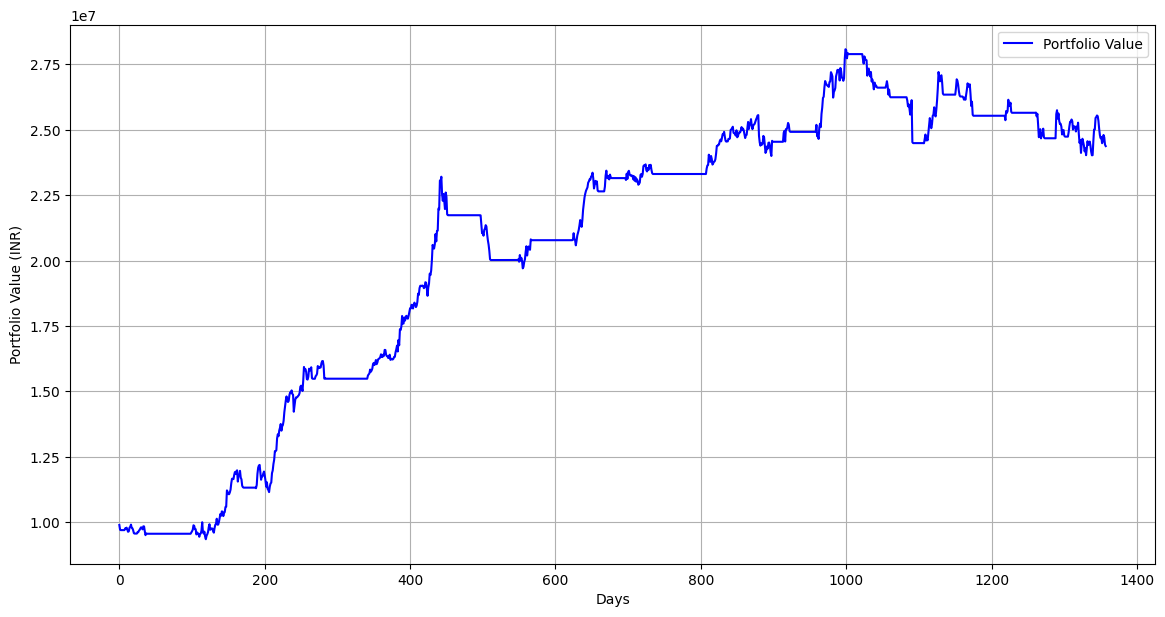

In [56]:
test_portfolio = []
positions = {}
improvise_regime , cash , positions= backtest_regime("2019-01-01", "2020-01-01" ,"2019-10-01" , "2025-07-01" , nifty_50_tickers , (24, 13, 9, 15,7) , True ,
                                                       10000000 , test_portfolio , positions_available= positions, mark_data = market_data)
#hardcoded_params = (long_ema , short_ema , signal_period , adx_period , holding_days)


# FINALLY BACKTESTING BY CHOOSING THE BEST PARAMS FOR 1 year TRAINING AND NEXT 6 MONTH FOR TESTING ON A ROLLING BASIS FROM TP: 2020 TO 2025

In [67]:
market_data = yf.download("^NSEI" , start="2019-01-01" , end="2025-08-01" , progress= False)
market_data.columns = ["Close" , "High", "Low", "Open", "Volume"]
market_data

,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,10792.500000,10895.349609,10735.049805,10868.849609,309700
2019-01-03,10672.250000,10814.049805,10661.250000,10796.799805,286200
2019-01-04,10727.349609,10741.049805,10628.650391,10699.700195,296600
2019-01-07,10771.799805,10835.950195,10750.150391,10804.849609,269400
2019-01-08,10802.150391,10818.450195,10733.250000,10786.250000,277700
...,...,...,...,...,...
2025-07-25,24837.000000,25010.349609,24806.349609,25010.349609,278100
2025-07-28,24680.900391,24889.199219,24646.599609,24782.449219,262100
2025-07-29,24821.099609,24847.150391,24598.599609,24609.650391,284700


In [61]:
import itertools

def best_params_fast(start_date, end_date , ticker_list , master_data):
    # 1. Download all required data ONCE outside the loop
    market_data = copy.deepcopy(master_data)
    training_data = {}
    for ticker in ticker_list:
        try:
            df = yf.download(ticker + ".NS", start=start_date, end=end_date , progress=False)
            df.columns = ["Close" , "High", "Low", "Open", "Volume"]
            training_data[ticker] = df
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")

    long_ema = [24,30,35]
    short_ema = [11,13]
    signal_ema = [9,10]
    adx_period = [15]
    no_of_stocks = [5,7,10]

    best_value = -float("inf")
    best_params = None

    # Use itertools.product for clean parameter grid search
    for long_macd, short, signal, adx , stocks in itertools.product(long_ema, short_ema, signal_ema, adx_period , no_of_stocks):
        # Filter out illogical combos
        if short >= long_macd or signal > short:
            continue

        data = copy.deepcopy(training_data)
        market_data = copy.deepcopy(master_data)
        data = prepare_dataset(data, short_ema=short, long_ema=long_macd, adx_period=adx, signal_ema=signal)
        data = generate_signals_3(data)
        market_data = market_data.loc[start_date:end_date]
        market_data = supertrend(market_data , period= 10 , multiplier= 3)
        portfolio ,  cash , positions  = run_strategy_regime(stock_data= data, market_trend_df=market_data , no_of_stocks= stocks)
        sharpe = sharpe_ratio(portfolio)
        print(f"for parameters {long_macd} , {short} , {signal} , {adx}, {stocks} the sharpe ratio was: {sharpe}")

        if sharpe > best_value:
            best_value = sharpe
            best_params = (long_macd, short, signal, adx , stocks)
            print("New best:", best_params, "with portfolio value:", best_value)

    print("Final best parameters:", best_params)
    return best_params


def backtest_regime(training_start , training_end , test_start , test_end , ticker_list , hardcoded_parameters , hardcoded_parameters_bool, cash_ , final_portfolio , positions_available , mark_data):
  if hardcoded_parameters_bool:
    best_parameters = hardcoded_parameters
  else:
    best_parameters = best_params_fast(training_start, training_end , ticker_list , master_data = mark_data)
  test_data = {}
  error = 50
  while error > 5:
      test_data = {}
      error = 0
      for ticker in ticker_list:
          try:
              df = yf.download(ticker + ".NS", start= test_start, end= test_end , progress= False)
              df.columns = ["Close" , "High", "Low", "Open", "Volume"]
              test_data[ticker] = df
          except Exception as e:
              #print(f"Error downloading {ticker}: {e}")
              error += 1

  test_data = prepare_dataset(test_data, short_ema=best_parameters[1], long_ema=best_parameters[0], adx_period=best_parameters[3], signal_ema=best_parameters[2])
  test_data = generate_signals_3(test_data)
  market_data = mark_data.loc[test_start:test_end]
  market_data = supertrend(market_data , period= 10 , multiplier= 3)
  portfolio ,  cash , positions = run_strategy_regime(stock_data=test_data, market_trend_df=market_data, initial_amount = cash_ , positions=positions_available , no_of_stocks= best_parameters[4])
  final_portfolio.extend(portfolio)
  plt.figure(figsize=(14, 7))
  plt.plot(final_portfolio, label='Portfolio Value', color='blue')
  plt.xlabel('Days')
  plt.ylabel('Portfolio Value (INR)')
  plt.legend()
  plt.grid()
  plt.show()
  return portfolio , cash , positions











In [94]:
# 📅 NIFTY 50 Constituents - Historical Timeline
# source wikepedia

# November 2019
tickers_nov2019 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "INFRATEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "GAIL", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "VEDL", "WIPRO", "YESBANK", "ZEEL"
]

# March 19, 2020
tickers_mar2020 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "INFRATEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "GAIL", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "VEDL", "WIPRO", "SHREECEM", "ZEEL"
]

# July 31, 2020
tickers_jul2020 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "INFRATEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "GAIL", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "SHREECEM", "ZEEL"
]

# September 25, 2020
tickers_sep2020 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "INFRATEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "GAIL", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "SHREECEM", "SBILIFE","ZEEL"
]

# March 31, 2021
tickers_mar2021 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "IOC", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "SHREECEM", "SBILIFE","ZEEL"
]

# March 31, 2022
tickers_mar2022 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "SHREECEM", "SBILIFE","ZEEL"
]

# September 30, 2022
tickers_sep2022 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "HDFC", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]

# July 13, 2023
tickers_jul2023 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "LTIM", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "UPL", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]

# March 28, 2024
tickers_mar2024 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "DIVISLAB", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "LTIM", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "SHRIRAMFIN", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]

# September 30, 2024
tickers_sep2024 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "BEL", "BPCL", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "LTIM", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "SHRIRAMFIN", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]

# March 28, 2025
tickers_mar2025 = [
    "ADANIPORTS", "ASIANPAINT", "AXISBANK", "BAJAJ-AUTO", "BAJFINANCE",
    "BAJAJFINSV", "BHARTIARTL", "BEL", "JIOFIN", "CIPLA",
    "COALINDIA", "DRREDDY", "EICHERMOT", "TATACONSUM", "GRASIM",
    "HCLTECH", "LTIM", "HDFCBANK", "HEROMOTOCO", "HINDALCO",
    "HINDUNILVR", "BRITANNIA", "ICICIBANK", "INDUSINDBK", "INFY",
    "APOLLOHOSP", "ITC", "JSWSTEEL", "KOTAKBANK", "LT",
    "M&M", "MARUTI", "NESTLEIND", "NTPC", "ONGC",
    "POWERGRID", "RELIANCE", "SBIN", "SUNPHARMA", "TCS",
    "TATAMOTORS", "TATASTEEL", "TECHM", "TITAN", "ULTRACEMCO",
    "SHRIRAMFIN", "HDFCLIFE", "WIPRO", "ADANIENT", "SBILIFE"
]


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading INFRATEL: Length mismatch: Expected axis has 6 elements, new values have 5 elements


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading HDFC: Length mismatch: Expected axis has 6 elements, new values have 5 elements
{Timestamp('2019-04-03 00:00:00')}
{Timestamp('2019-12-30 00:00:00')}
number of free days for trading = 2
number of days data not available = 180
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: -0.32497940748551624
New best: (24, 11, 9, 15, 5) with portfolio value: -0.32497940748551624
{Timestamp('2019-04-03 00:00:00')}
{Timestamp('2019-12-30 00:00:00')}
number of free days for trading = 2
number of days data not available = 180
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: -0.5208950041326085
{Timestamp('2019-04-03 00:00:00')}
{Timestamp('2019-12-30 00:00:00')}
number of free days for trading = 3
number of days data not available = 180
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: -0.693781330052885
{Timestamp('2019-04-03 00:00:00')}
{Timestamp('2019-12-

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


{Timestamp('2020-01-02 00:00:00')}
{Timestamp('2020-02-27 00:00:00')}
number of free days for trading = 6
number of days data not available = 8
total number of testing_days = 40


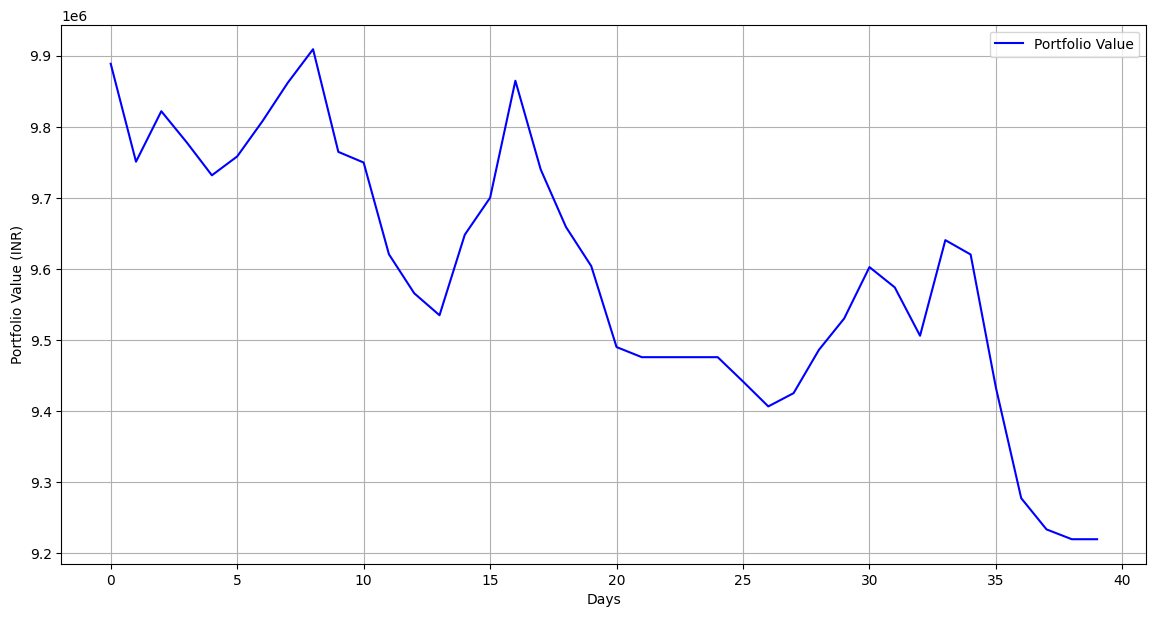

In [95]:
final_portfolio = []
positions = {}
portfolio_iter1 , cash , positions  = backtest_regime("2019-01-01", "2020-01-01" ,"2019-10-01" , "2020-03-01" , tickers_nov2019 , (24, 13, 9, 15) , False , 10000000 ,
                                                      final_portfolio , positions_available= positions , mark_data= market_data)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading INFRATEL: Length mismatch: Expected axis has 6 elements, new values have 5 elements


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading HDFC: Length mismatch: Expected axis has 6 elements, new values have 5 elements
{Timestamp('2019-06-07 00:00:00')}
{Timestamp('2020-02-27 00:00:00')}
number of free days for trading = 6
number of days data not available = 148
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: -0.316788648197817
New best: (24, 11, 9, 15, 5) with portfolio value: -0.316788648197817
{Timestamp('2019-06-07 00:00:00')}
{Timestamp('2020-02-27 00:00:00')}
number of free days for trading = 6
number of days data not available = 148
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: -0.47067268686061275
{Timestamp('2019-06-07 00:00:00')}
{Timestamp('2020-02-27 00:00:00')}
number of free days for trading = 7
number of days data not available = 148
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: -0.6559604967134022
{Timestamp('2019-06-07 00:00:00')}
{Timestamp('2020-02-27

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


{Timestamp('2020-02-28 00:00:00')}
{Timestamp('2020-06-29 00:00:00')}
number of free days for trading = 59
number of days data not available = 0
total number of testing_days = 80


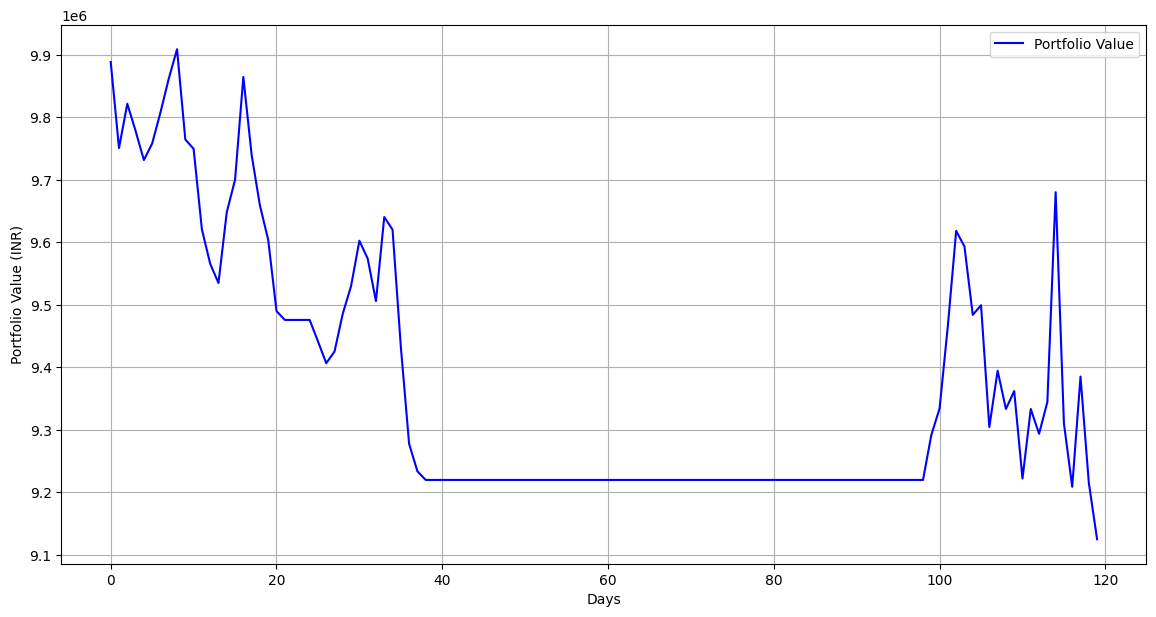

In [96]:
portfolio_iter2, cash , positions = backtest_regime("2019-03-01", "2020-03-01" ,"2019-12-01" , "2020-07-01" , tickers_mar2020 , (24, 13, 9, 15) , False ,
                                                    cash , final_portfolio ,positions_available=positions, mark_data= market_data)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading INFRATEL: Length mismatch: Expected axis has 6 elements, new values have 5 elements


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading HDFC: Length mismatch: Expected axis has 6 elements, new values have 5 elements
{Timestamp('2020-03-31 00:00:00')}
{Timestamp('2020-06-29 00:00:00')}
number of free days for trading = 38
number of days data not available = 0
total number of testing_days = 59
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: -1.1009760219650702
New best: (24, 11, 9, 15, 5) with portfolio value: -1.1009760219650702
{Timestamp('2020-03-31 00:00:00')}
{Timestamp('2020-06-29 00:00:00')}
number of free days for trading = 38
number of days data not available = 0
total number of testing_days = 59
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: -1.0542504199979492
New best: (24, 11, 9, 15, 7) with portfolio value: -1.0542504199979492
{Timestamp('2020-03-31 00:00:00')}
{Timestamp('2020-06-29 00:00:00')}
number of free days for trading = 38
number of days data not available = 0
total number of testing_days = 59
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: -1.05741743

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


{Timestamp('2020-07-06 00:00:00')}
{Timestamp('2020-08-28 00:00:00')}
number of free days for trading = 0
number of days data not available = 0
total number of testing_days = 40


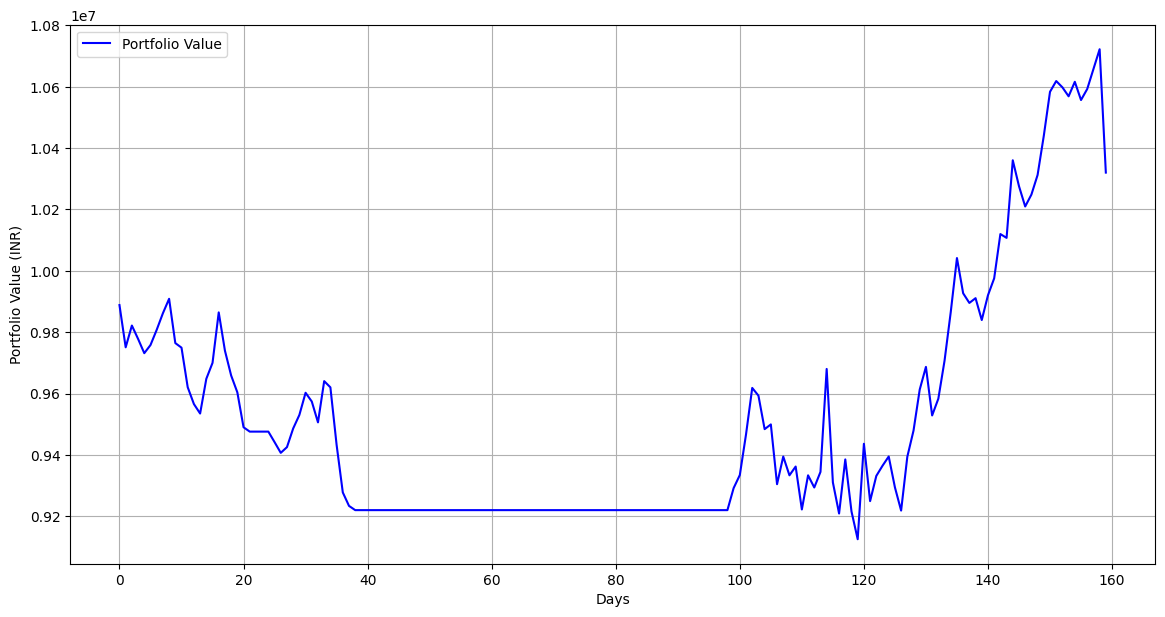

In [97]:
portfolio_iter3, cash , positions = backtest_regime("2020-01-01", "2020-07-01" ,"2020-04-01" ,  "2020-09-01" , tickers_jul2020 , (24, 13, 9, 15) , False ,
                                                    cash , final_portfolio ,positions_available=positions, mark_data= market_data)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading INFRATEL: Length mismatch: Expected axis has 6 elements, new values have 5 elements


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading HDFC: Length mismatch: Expected axis has 6 elements, new values have 5 elements
{Timestamp('2019-12-05 00:00:00')}
{Timestamp('2020-08-28 00:00:00')}
number of free days for trading = 67
number of days data not available = 27
total number of testing_days = 183
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: 0.454576120952443
New best: (24, 11, 9, 15, 5) with portfolio value: 0.454576120952443
{Timestamp('2019-12-05 00:00:00')}
{Timestamp('2020-08-28 00:00:00')}
number of free days for trading = 67
number of days data not available = 27
total number of testing_days = 183
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: 0.6632826542710365
New best: (24, 11, 9, 15, 7) with portfolio value: 0.6632826542710365
{Timestamp('2019-12-05 00:00:00')}
{Timestamp('2020-08-28 00:00:00')}
number of free days for trading = 67
number of days data not available = 27
total number of testing_days = 183
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: 0.769119930

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFRATEL.NS']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


{Timestamp('2020-08-26 00:00:00')}
{Timestamp('2021-02-25 00:00:00')}
number of free days for trading = 25
number of days data not available = 1
total number of testing_days = 128


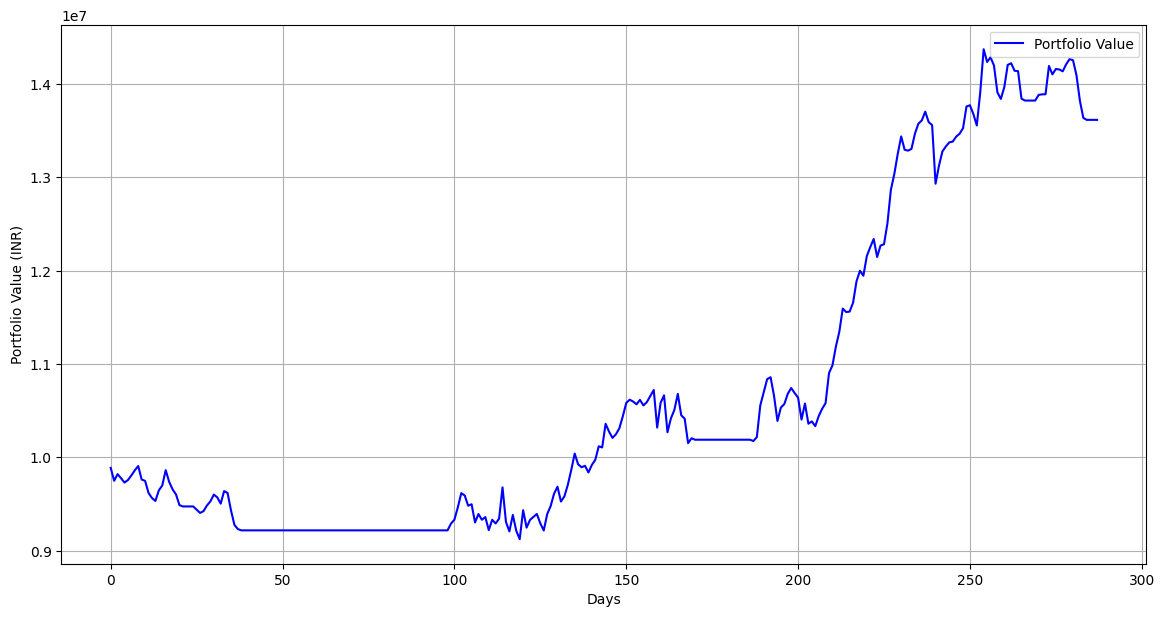

In [98]:
portfolio_iter4 , cash , positions= backtest_regime("2019-09-01", "2020-09-01" ,"2020-06-01" ,  "2021-03-01" , tickers_sep2020 , (24, 13, 9, 15) , False , cash , final_portfolio ,positions_available=positions, mark_data= market_data)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading HDFC: Length mismatch: Expected axis has 6 elements, new values have 5 elements
{Timestamp('2020-06-05 00:00:00')}
{Timestamp('2021-02-25 00:00:00')}
number of free days for trading = 25
number of days data not available = 1
total number of testing_days = 186
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: 2.5411254592230668
New best: (24, 11, 9, 15, 5) with portfolio value: 2.5411254592230668
{Timestamp('2020-06-05 00:00:00')}
{Timestamp('2021-02-25 00:00:00')}
number of free days for trading = 25
number of days data not available = 1
total number of testing_days = 186
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: 2.6224283507148876
New best: (24, 11, 9, 15, 7) with portfolio value: 2.6224283507148876
{Timestamp('2020-06-05 00:00:00')}
{Timestamp('2021-02-25 00:00:00')}
number of free days for trading = 25
number of days data not available = 1
total number of testing_days = 186
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: 2.7554747212

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


{Timestamp('2021-03-01 00:00:00')}
{Timestamp('2022-02-25 00:00:00')}
number of free days for trading = 123
number of days data not available = 0
total number of testing_days = 247


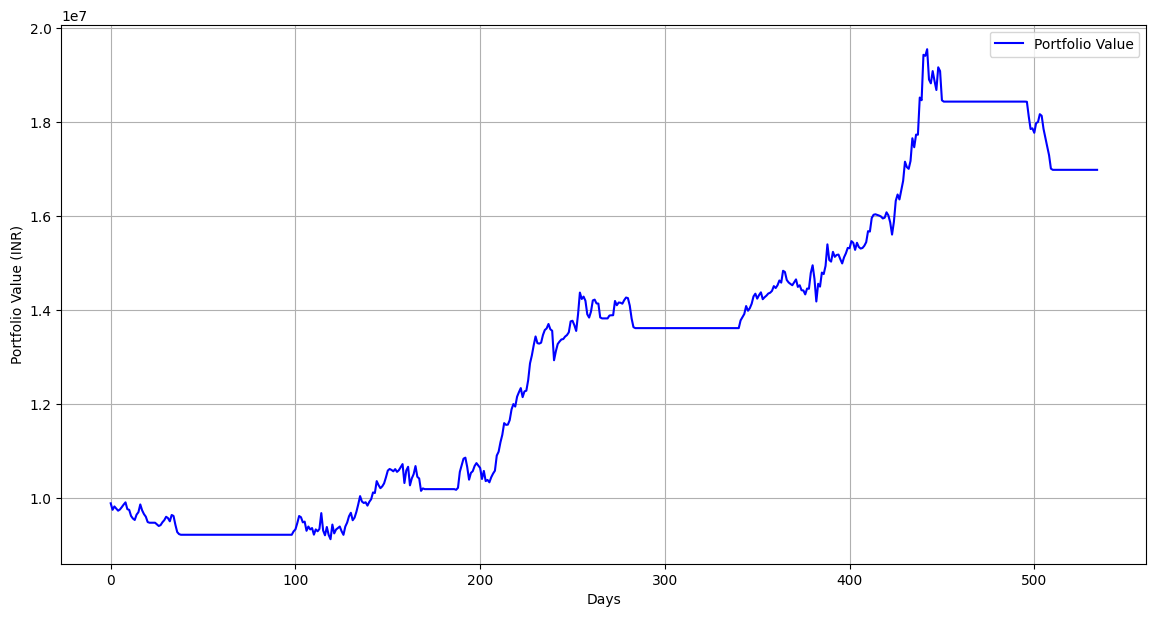

In [99]:
portfolio_iter5, cash , positions = backtest_regime("2020-03-01", "2021-03-01" ,"2020-12-01" ,  "2022-03-01" , tickers_mar2021 , (24, 13, 9, 15) , False ,cash , final_portfolio ,positions_available=positions, mark_data= market_data)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading HDFC: Length mismatch: Expected axis has 6 elements, new values have 5 elements
{Timestamp('2021-06-03 00:00:00')}
{Timestamp('2022-02-25 00:00:00')}
number of free days for trading = 70
number of days data not available = 0
total number of testing_days = 185
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: 1.733684860729068
New best: (24, 11, 9, 15, 5) with portfolio value: 1.733684860729068
{Timestamp('2021-06-03 00:00:00')}
{Timestamp('2022-02-25 00:00:00')}
number of free days for trading = 70
number of days data not available = 0
total number of testing_days = 185
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: 1.7886441501656187
New best: (24, 11, 9, 15, 7) with portfolio value: 1.7886441501656187
{Timestamp('2021-06-03 00:00:00')}
{Timestamp('2022-02-25 00:00:00')}
number of free days for trading = 70
number of days data not available = 0
total number of testing_days = 185
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: 1.816908846015

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


{Timestamp('2022-02-28 00:00:00')}
{Timestamp('2022-08-29 00:00:00')}
number of free days for trading = 70
number of days data not available = 0
total number of testing_days = 124


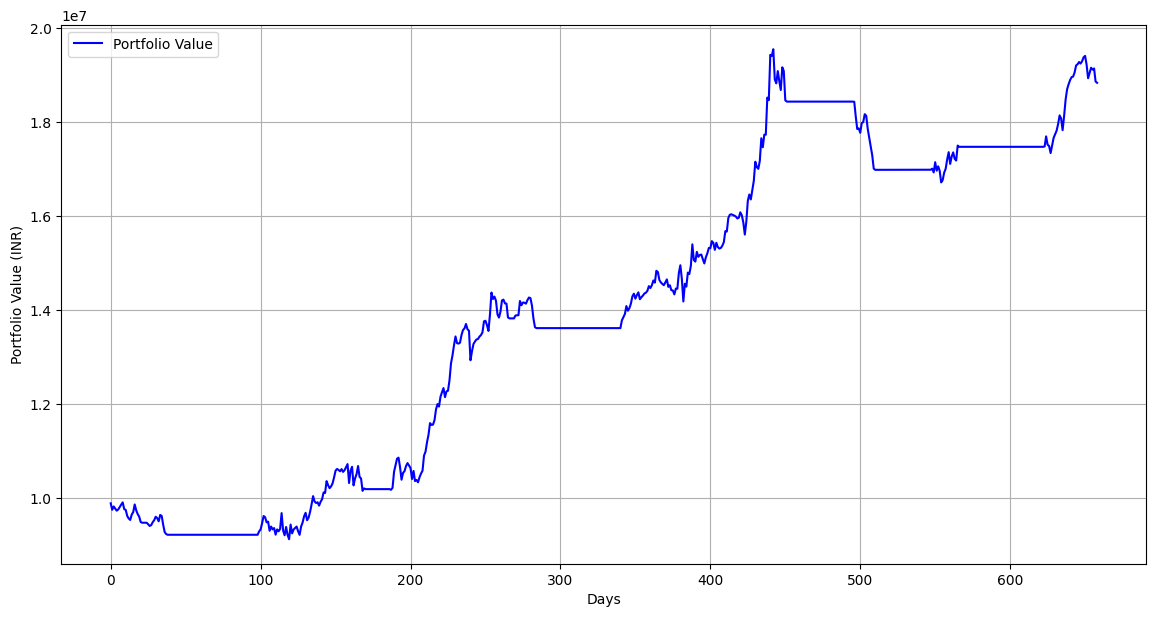

In [100]:
portfolio_iter6 , cash , positions= backtest_regime("2021-03-01", "2022-03-01" ,"2021-12-01" ,  "2022-09-01" , tickers_mar2022 , (24, 13, 9, 15) , False , cash , final_portfolio ,positions_available=positions, mark_data= market_data)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


Error downloading HDFC: Length mismatch: Expected axis has 6 elements, new values have 5 elements
{Timestamp('2021-12-02 00:00:00')}
{Timestamp('2022-08-29 00:00:00')}
number of free days for trading = 117
number of days data not available = 0
total number of testing_days = 185
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: 0.7620681532621904
New best: (24, 11, 9, 15, 5) with portfolio value: 0.7620681532621904
{Timestamp('2021-12-02 00:00:00')}
{Timestamp('2022-08-29 00:00:00')}
number of free days for trading = 117
number of days data not available = 0
total number of testing_days = 185
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: 0.796126793533893
New best: (24, 11, 9, 15, 7) with portfolio value: 0.796126793533893
{Timestamp('2021-12-02 00:00:00')}
{Timestamp('2022-08-29 00:00:00')}
number of free days for trading = 117
number of days data not available = 0
total number of testing_days = 185
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: 0.649402961

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


{Timestamp('2022-08-30 00:00:00')}
{Timestamp('2023-06-28 00:00:00')}
number of free days for trading = 102
number of days data not available = 0
total number of testing_days = 206


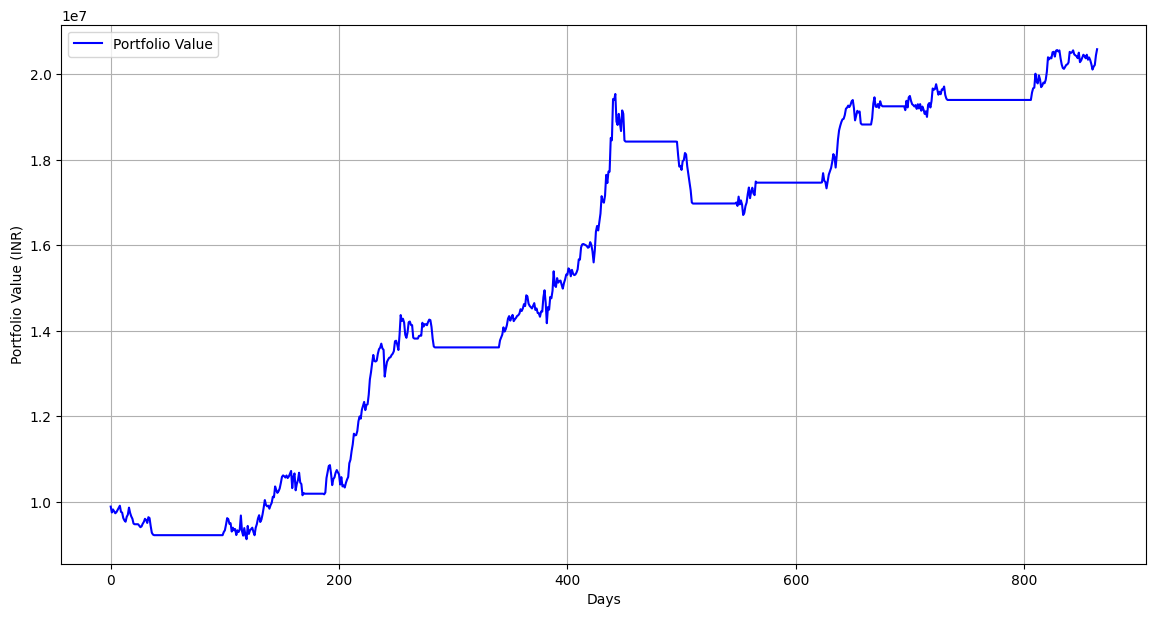

In [101]:
portfolio_iter7 , cash , positions= backtest_regime("2021-09-01", "2022-09-01" ,"2022-06-01" ,  "2023-07-01" , tickers_sep2022 , (24, 13, 9, 15) , False , cash , final_portfolio ,positions_available=positions, mark_data= market_data)


{Timestamp('2022-09-30 00:00:00')}
{Timestamp('2023-06-28 00:00:00')}
number of free days for trading = 89
number of days data not available = 0
total number of testing_days = 184
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: 1.129158884777015
New best: (24, 11, 9, 15, 5) with portfolio value: 1.129158884777015
{Timestamp('2022-09-30 00:00:00')}
{Timestamp('2023-06-28 00:00:00')}
number of free days for trading = 89
number of days data not available = 0
total number of testing_days = 184
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: 1.270717352955701
New best: (24, 11, 9, 15, 7) with portfolio value: 1.270717352955701
{Timestamp('2022-09-30 00:00:00')}
{Timestamp('2023-06-28 00:00:00')}
number of free days for trading = 89
number of days data not available = 0
total number of testing_days = 184
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: 1.6586444834052594
New best: (24, 11, 9, 15, 10) with portfolio value: 1.6586444834052594
{Timestamp('2022-09-30 0

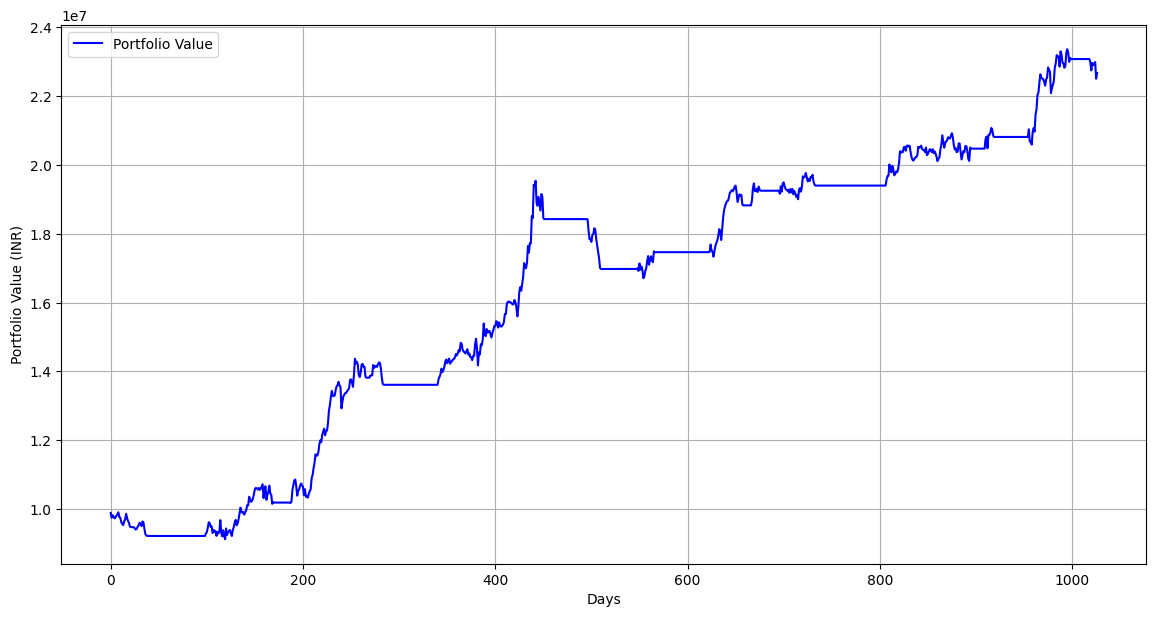

In [102]:
portfolio_iter8 , cash , positions= backtest_regime("2022-07-01", "2023-07-01" ,"2023-04-01" ,  "2024-03-01" , tickers_jul2023 , (24, 13, 9, 15) , False , cash , final_portfolio ,positions_available=positions, mark_data= market_data)



{Timestamp('2023-06-05 00:00:00')}
{Timestamp('2024-02-28 00:00:00')}
number of free days for trading = 71
number of days data not available = 0
total number of testing_days = 183
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: 1.157891443349813
New best: (24, 11, 9, 15, 5) with portfolio value: 1.157891443349813
{Timestamp('2023-06-05 00:00:00')}
{Timestamp('2024-02-28 00:00:00')}
number of free days for trading = 71
number of days data not available = 0
total number of testing_days = 183
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: 1.119569555973819
{Timestamp('2023-06-05 00:00:00')}
{Timestamp('2024-02-28 00:00:00')}
number of free days for trading = 71
number of days data not available = 0
total number of testing_days = 183
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: 1.0639309227282399
{Timestamp('2023-06-05 00:00:00')}
{Timestamp('2024-02-28 00:00:00')}
number of free days for trading = 71
number of days data not available = 0
total number of tes

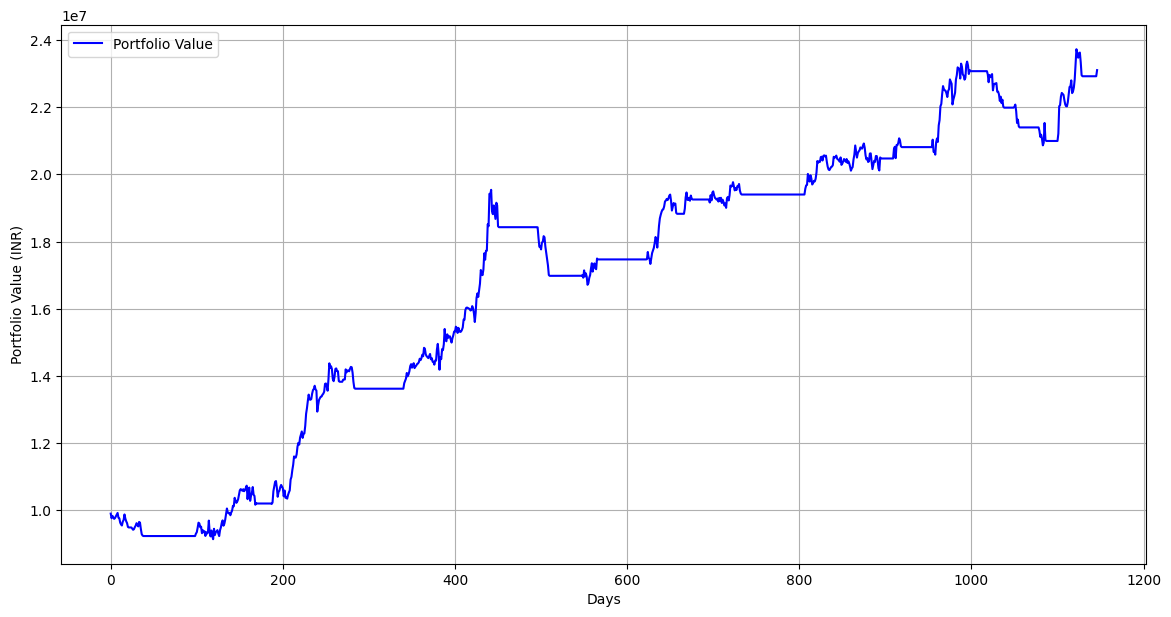

In [103]:
portfolio_iter9 , cash , positions= backtest_regime("2023-03-01", "2024-03-01" ,"2023-12-01" ,  "2024-09-01" , tickers_mar2024 , (24, 13, 9, 15) , False,cash , final_portfolio ,positions_available=positions, mark_data= market_data)


{Timestamp('2023-12-05 00:00:00')}
{Timestamp('2024-08-29 00:00:00')}
number of free days for trading = 86
number of days data not available = 0
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: -0.33537187974064725
New best: (24, 11, 9, 15, 5) with portfolio value: -0.33537187974064725
{Timestamp('2023-12-05 00:00:00')}
{Timestamp('2024-08-29 00:00:00')}
number of free days for trading = 86
number of days data not available = 0
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: -0.3282366493274838
New best: (24, 11, 9, 15, 7) with portfolio value: -0.3282366493274838
{Timestamp('2023-12-05 00:00:00')}
{Timestamp('2024-08-29 00:00:00')}
number of free days for trading = 86
number of days data not available = 0
total number of testing_days = 180
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: -0.3664733528130976
{Timestamp('2023-12-05 00:00:00')}
{Timestamp('2024-08-29 00:00:00')}
number of free

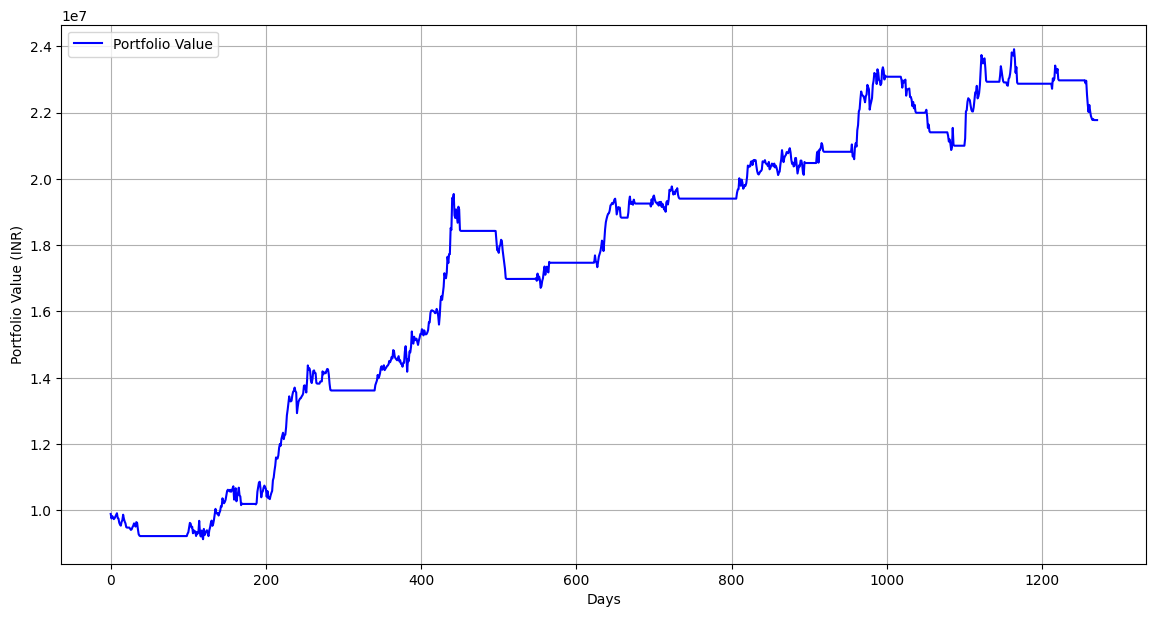

In [104]:
portfolio_iter10, cash , positions = backtest_regime("2023-09-01", "2024-09-01" ,"2024-06-01" ,  "2025-03-01" , tickers_sep2024 , (24, 13, 9, 15) , False ,cash , final_portfolio ,positions_available=positions, mark_data= market_data)



{Timestamp('2024-06-06 00:00:00')}
{Timestamp('2025-02-27 00:00:00')}
number of free days for trading = 115
number of days data not available = 0
total number of testing_days = 184
for parameters 24 , 11 , 9 , 15, 5 the sharpe ratio was: 0.24518166267144642
New best: (24, 11, 9, 15, 5) with portfolio value: 0.24518166267144642
{Timestamp('2024-06-06 00:00:00')}
{Timestamp('2025-02-27 00:00:00')}
number of free days for trading = 115
number of days data not available = 0
total number of testing_days = 184
for parameters 24 , 11 , 9 , 15, 7 the sharpe ratio was: 0.515283438000427
New best: (24, 11, 9, 15, 7) with portfolio value: 0.515283438000427
{Timestamp('2024-06-06 00:00:00')}
{Timestamp('2025-02-27 00:00:00')}
number of free days for trading = 115
number of days data not available = 0
total number of testing_days = 184
for parameters 24 , 11 , 9 , 15, 10 the sharpe ratio was: 0.3640831156308155
{Timestamp('2024-06-06 00:00:00')}
{Timestamp('2025-02-27 00:00:00')}
number of free day

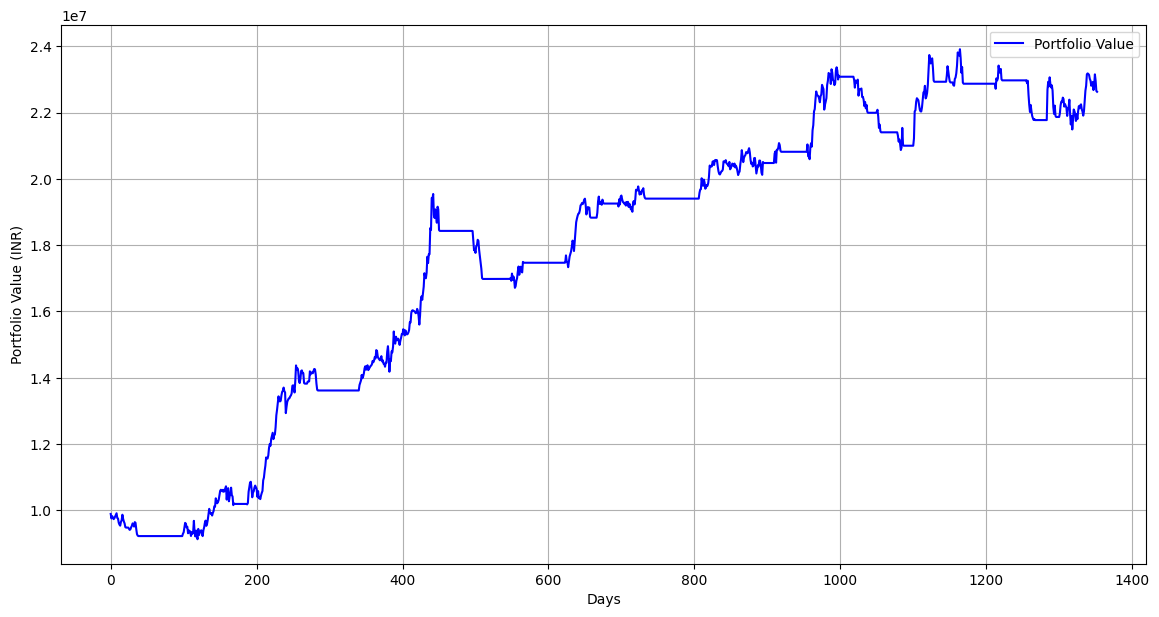

In [105]:
portfolio_iter11 , cash , positions= backtest_regime("2024-03-01", "2025-03-01" ,"2024-12-01" ,  "2025-07-01" , tickers_mar2025 , (24, 13, 9, 15) , False, cash , final_portfolio ,positions_available=positions, mark_data= market_data)


# CAMPARISION WITH BENCHMARK

[*********************100%***********************]  1 of 1 completed


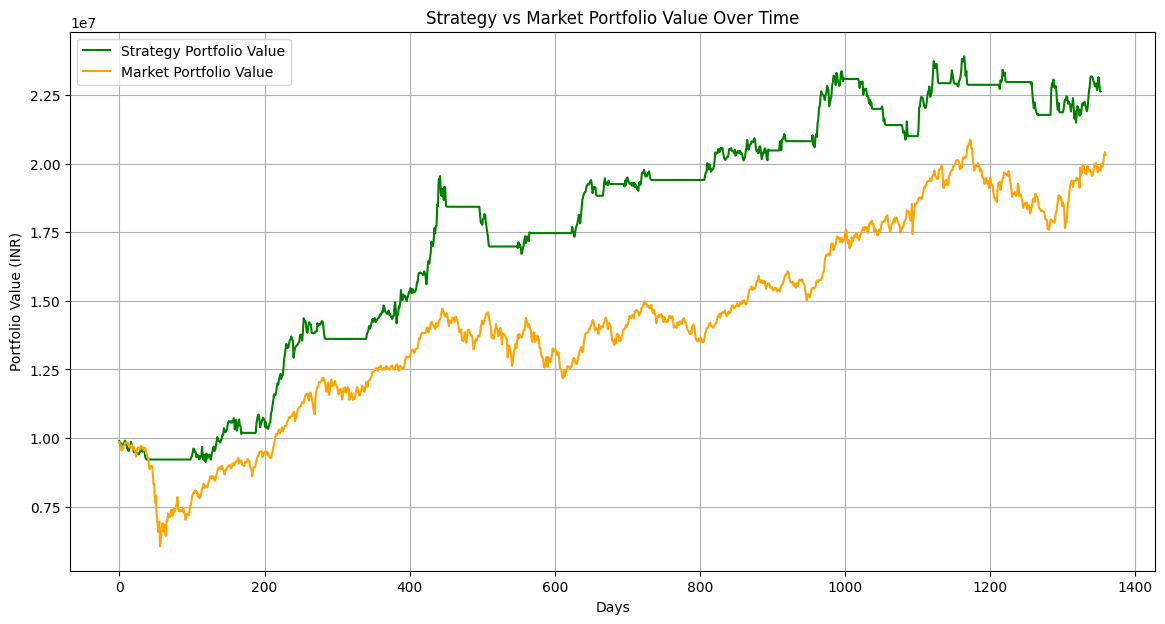

In [106]:
market_data = yf.download("^NSEI", start="2020-01-01", end="2025-07-01")
market_data.columns = ["Close" , "High", "Low", "Open", "Volume"]
market_portfolio = [10000000*0.985]
for day in range(1,len(market_data)):
    returns = market_data['Close'][day] / market_data['Close'][0]
    market_portfolio.append(market_portfolio[0] * returns*0.985)

plt.figure(figsize=(14, 7))
plt.plot(final_portfolio , label='Strategy Portfolio Value', color='green')
# plt.plot(final_portfolio, label='Final Portfolio Value', color='red')
plt.plot(market_portfolio, label='Market Portfolio Value', color='orange')
plt.title('Strategy vs Market Portfolio Value Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid()
plt.show()

In [107]:
def strategy_evaluation(portfolios_dict):
    metric_df = {}
    for name, portfolio in portfolios_dict.items():
        sharpe = sharpe_ratio(portfolio)
        sortino = sortino_ratio(portfolio)
        profit = profit_factor(portfolio)
        drawdown = max_drawdown(portfolio)
        cagr = calculate_cagr(portfolio)
        pnl = calculate_pnl(portfolio)

        metric_df[name] = {  # ✅ name as key
            "Sharpe Ratio": sharpe,
            "Sortino Ratio": sortino,
            "Profit Factor": profit,
            "Max Drawdown": drawdown,
            "CAGR": cagr,
            "Total PnL": pnl
        }
    return metric_df

portfolios = {
    "Market Portfolio": market_portfolio,
    "Strategy 2": final_portfolio
}

comparison_df = pd.DataFrame(strategy_evaluation(portfolios)).T
comparison_df


,Sharpe Ratio,Sortino Ratio,Profit Factor,Max Drawdown,CAGR,Total PnL
Market Portfolio,0.810828,0.930680,1.169675,-0.384683,0.143617,1.047200e+07
Strategy 2,1.251814,1.450178,1.333959,-0.144902,0.166695,1.273832e+07
